# Custom `create_rag_agent` function

In this tutorial, we will build a custom `create_rag_agent` function that resembles the `langgraph.prebuilt.create_react_agent` function.

The `create_react_agent` helps with fast prototyping of a typical `ReAct` agent.
The `create_rag_agent` helps with fast prototyping of a typical `RAG` agent.

The `create_rag_agent` has more moving parts and configuration points. But the idea is the same: get a typical RAG agent without ceremony.

To build a typical RAG, we need these parts:
- a `LLM` for reasoning and text generation
- a `vector store` which also requires an `embedding model`
- We can also use the `retriever tool` that encapsulates the `vector store`. We use the 'retriever_tool' in this notebook.

We initialize them outside the `create_rag_agent` function and pass them into the function as arguments.
We also fill in our vector store outside the `create_rag_agent` function.

### RAG functionality

We add 3 typical RAG features:
- query transformation. It runs if the agent didn't find a relevant answer or if the retrieved documents are not relevant to the query. It can run several times.
- [optional] external search tools. It could be a web search, or Wikipedia search, or arXiv search, or other tools. It helps by searching for necessary information in external data sources.
- [optional] document grading. It verifies if the retrieved information is relevant to the query.


## Setup

In [1]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

### Initialize LLM

In [2]:
_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ········


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", )

# Simple text invocation
result = llm.invoke("Sing a ballad of LangChain in one sentence.")
print(result.content)

Oh, LangChain, you weaver of thought and tool, you chain the LLM's vast mind to the world's deep truth, birthing agents that learn and soar across data's boundless sea.


### Initialize tools

In [4]:
from langchain_community.tools.arxiv import ArxivQueryRun

arxiv_tool = ArxivQueryRun()

In [5]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [6]:
from langchain_community.tools import DuckDuckGoSearchResults

web_tool = DuckDuckGoSearchResults()

In [7]:
tools = [arxiv_tool, wikipedia_tool, web_tool]

### Initialize Vector store as a retriever tool

We scrap several documents and use them for a new vector store.

In [8]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]
len(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


3

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)
len(doc_splits)

540

In [10]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")

# In this example, use only 10 chunks
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits[:10], embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [11]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [12]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward 

### Initialize RAG agent

We store code of the `create_rag_agent` and `RagState` in a separate Python file.

In [13]:
from rag_agent_executor import create_rag_agent, RagState

## Examples

### Use document grading, no external information

In [14]:
agent = create_rag_agent(
        llm=llm,
        embedding_model=None, # Not used if retriever_tool is present
        vector_store=None, # Not used if retriever_tool is present
        retriever_tool=retriever_tool,
    external_search_tools=None,
        do_document_grading=True,
        do_external_search=False,
        checkpointer=None,
        debug=False,
    )

In [15]:
response = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
)

---RETRIEVING DOCUMENTS---
---ROUTING AFTER RETRIEVAL (iteration 1, phase iter 0)---
Documents found by primary retriever.
---GRADING DOCUMENTS---
Document assessment: relevant
---ROUTING AFTER GRADING (assessment: relevant)---
Documents relevant. Proceeding to generate.
---GENERATING ANSWER---
Generated answer: Lilian Weng, in her article "Reward Hacking in Reinforcement Learning," categorizes types of reward ...
---ROUTING AFTER GENERATION---
Answer seems sufficient. Ending.


### Use external information, no document grading

In [16]:
agent = create_rag_agent(
        llm=llm,
        embedding_model=None, # Not used if retriever_tool is present
        vector_store=None, # Not used if retriever_tool is present
        retriever_tool=retriever_tool,
    external_search_tools=tools,
        do_document_grading=False,
        do_external_search=True,
        checkpointer=None,
        debug=False,
    )

In [18]:
response = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the blue team and red team?",
            }
        ]
    }
)

---RETRIEVING DOCUMENTS---
---ROUTING AFTER RETRIEVAL (iteration 1, phase iter 0)---
Documents found by primary retriever.
---GENERATING ANSWER---
Generated answer: The provided documents discuss "reward hacking" in the context of reinforcement learning (RL) and ho...
---ROUTING AFTER GENERATION---
Answer deemed insufficient.
Attempting external search due to insufficient answer.
---PERFORMING EXTERNAL SEARCH---
Invoking external search tool: arxiv
Invoking external search tool: wikipedia
Invoking external search tool: duckduckgo_results_json
Error invoking external search tool duckduckgo_results_json: Client.__init__() got an unexpected keyword argument 'proxies'
Found 2 documents from external search.
---ROUTING AFTER EXTERNAL SEARCH---
Documents found from external search.
---GENERATING ANSWER---
Generated answer: Based on the retrieved documents, the "red team" and "blue team" are terms primarily used in context...
---ROUTING AFTER GENERATION---
Answer seems sufficient. Ending.


### Use external information and document grading

In [20]:
agent = create_rag_agent(
        llm=llm,
        embedding_model=None, # Not used if retriever_tool is present
        vector_store=None, # Not used if retriever_tool is present
        retriever_tool=retriever_tool,
    external_search_tools=tools,
        do_document_grading=True,
        do_external_search=True,
        checkpointer=None,
        debug=False,
    )

In [21]:
response = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the blue team and red team?",
            }
        ]
    }
)

---RETRIEVING DOCUMENTS---
---ROUTING AFTER RETRIEVAL (iteration 1, phase iter 0)---
Documents found by primary retriever.
---GRADING DOCUMENTS---
Document assessment: not_relevant
---ROUTING AFTER GRADING (assessment: not_relevant)---
Documents assessment: not_relevant. Fallback options.
Attempting external search due to poor grading.
---PERFORMING EXTERNAL SEARCH---
Invoking external search tool: arxiv
Invoking external search tool: wikipedia
Invoking external search tool: duckduckgo_results_json
Error invoking external search tool duckduckgo_results_json: Client.__init__() got an unexpected keyword argument 'proxies'
Found 2 documents from external search.
---ROUTING AFTER EXTERNAL SEARCH---
Documents found from external search.
---GRADING DOCUMENTS---
Document assessment: relevant
---ROUTING AFTER GRADING (assessment: relevant)---
Documents relevant. Proceeding to generate.
---GENERATING ANSWER---
Generated answer: Based on the retrieved documents, here's an explanation of the blue

## Visualize

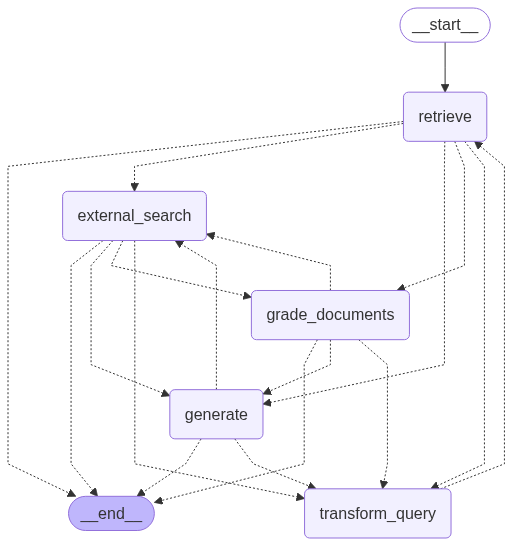

In [22]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))